In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn import linear_model
from math import *
from util import *

plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
# parseo con fechas
df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv', parse_dates=[0])
# rename de columnas
df.columns = ['dt', 'avg', 'error', 'country']
# toordinal() para tener una fecha numerica monotona
df['ordinal'] = df['dt'].apply(lambda d: d.toordinal())
# filtro los NaN
df = df[df.avg.notnull()]
df.head()

,dt,avg,error,country,ordinal
0,1743-11-01,4.384,2.294,Åland,636557
5,1744-04-01,1.530,4.680,Åland,636709
6,1744-05-01,6.702,1.789,Åland,636739
7,1744-06-01,11.609,1.577,Åland,636770
8,1744-07-01,15.342,1.410,Åland,636800


In [3]:
d1960 = datetime(1960, 1, 1)
d1990 = datetime(1990, 1, 1)
data1960_1990 = df[(d1960 < df['dt']) & (df['dt']< d1990)].groupby('country', as_index=False)['avg'].mean()
data1960_1990.head()

,country,avg
0,Afghanistan,14.230730
1,Africa,24.254075
2,Albania,12.792914
3,Algeria,23.256357
4,American_Samoa,26.772630


# Media histórica

In [15]:
means = df.groupby('country', as_index=False)['avg'].mean()
means = means.set_index('country')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.set_index('name')
join = world.join(means, how='inner').to_crs('+proj=natearth')
join.plot(column='avg', cmap='RdBu_r', scheme='quantiles', legend=True)

,pop_est,continent,iso_a3,gdp_md_est,geometry,avg
Afghanistan,2.840000e+07,Asia,AFG,22270.0,"POLYGON ((5570867.211288711 4012529.621796565,...",14.045007
Angola,1.279929e+07,Africa,AGO,110300.0,(POLYGON ((1579936.269004829 -659108.641772582...,21.824549
Albania,3.639453e+06,Europe,ALB,21810.0,"POLYGON ((1825604.590661876 4708723.758703761,...",12.610646
Argentina,4.091358e+07,South America,ARG,573900.0,(POLYGON ((-5381629.060866146 -6163383.9810883...,14.621194
Armenia,2.967004e+06,Asia,ARM,18770.0,"POLYGON ((3877796.130121168 4623489.043543667,...",8.551648
Australia,2.126264e+07,Oceania,AUS,800200.0,(POLYGON ((12954398.4442315 -4589995.177416694...,21.624697
Austria,8.210281e+06,Europe,AUT,329500.0,"POLYGON ((1457767.094186468 5401927.752826465,...",6.210732
Azerbaijan,8.238672e+06,Asia,AZE,77610.0,(POLYGON ((4028219.184326267 4472169.234487186...,11.175936
Burundi,8.988091e+06,Africa,BDI,3102.0,POLYGON ((2841144.425244962 -504602.2320376824...,20.070990
Belgium,1.041434e+07,Europe,BEL,389300.0,"POLYGON ((279249.4670030013 5752017.536075437,...",9.483378


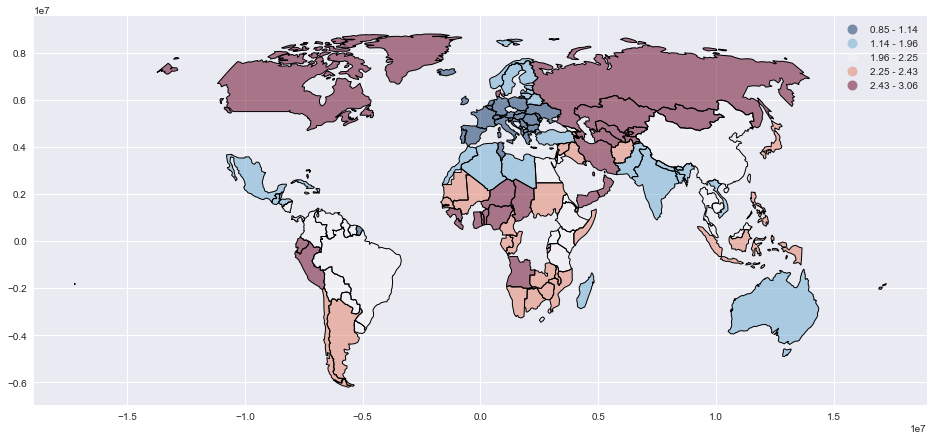

In [17]:
countries = join.index.unique()
p = sns.color_palette("hls", len(countries))
fns = poly(1)

def get_pendiente(c):
    sub_df = df[df['country'] == c]
    A = np.array([fns(x) for x in sub_df['ordinal']], dtype=np.float64)
    ws = np.linalg.lstsq(A, sub_df['avg'])[0]
    return ws[0]*10**5

pendientes = pd.DataFrame({'country': countries, 'pendiente': list(map(get_pendiente, countries))})
pendientes = pendientes.set_index('country')
world.join(pendientes, how='inner')\
    .to_crs('+proj=natearth')\
    .plot(column='pendiente', cmap='RdBu_r', scheme='quantiles', legend=True)